---
title: Assignment 04
author:
  - name: Dakota Alder
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: '2025-10-05'
date-modified: today
date-format: long
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2

execute:
  echo: false
  eval: false
  freeze: auto
---

# Github Repository: 

https://github.com/met-ad-688/assignment-04-dakotalder

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

np.random.seed(42)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("data/lightcast_job_postings.csv")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/09 01:29:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Feature Engineering

In the following code, I selected only the columns that I wanted to use for my regression models. I then grouped the remote type name column into 3 categories, the Employment type name column into 3 categories, and replaced all Null values in the Duration column with the median of that column. This left me with over 22,000 rows of clean data (after removing Null values in the Target column 'SALARY').

In [ ]:
#Missing Value Treatment
#| eval: true
#| echo: true
#| fig-align: center

df_cleaned = df.select(
    "SALARY", "DURATION", "MIN_YEARS_EXPERIENCE", "EMPLOYMENT_TYPE_NAME",
    "REMOTE_TYPE_NAME", "IS_INTERNSHIP"
)

#Cleaning the Remote Type Column
from pyspark.sql.functions import when, col
df_cleaned = df_cleaned.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when(col("REMOTE_TYPE_NAME") == "[None]", "On-site")
    .when(col("REMOTE_TYPE_NAME").isNull(), "On-site")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "On-site")
    .otherwise(col("REMOTE_TYPE_NAME"))
)



#Cleaning the Employment Type Column
df_cleaned = df_cleaned.withColumn(
    "EMPLOYMENT_TYPE_NAME",
    when(col("EMPLOYMENT_TYPE_NAME") == "Part-time / full-time", "Flexible")
    .when(col("EMPLOYMENT_TYPE_NAME").isNull(), "Full-Time")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Part-time (â‰¤ 32 hours)", "Part-Time")
    .when(col("EMPLOYMENT_TYPE_NAME") == "Full-time (> 32 hours)", "Full-Time")
    .otherwise(col("EMPLOYMENT_TYPE_NAME")) 
)

#Cleaning Duration (Adding Median to Nulls)
median_duration = df_cleaned.approxQuantile("DURATION", [0.5], 0.01)[0]
df_cleaned = df_cleaned.withColumn(
    "DURATION",
    when(col("DURATION").isNull(), median_duration).otherwise(col("DURATION"))
)
df_cleaned.show(5, truncate=False)

+------+--------+--------------------+--------------------+----------------+-------------+
|SALARY|DURATION|MIN_YEARS_EXPERIENCE|EMPLOYMENT_TYPE_NAME|REMOTE_TYPE_NAME|IS_INTERNSHIP|
+------+--------+--------------------+--------------------+----------------+-------------+
|NULL  |6.0     |2                   |Full-Time           |On-site         |false        |
|NULL  |18.0    |3                   |Full-Time           |Remote          |false        |
|NULL  |35.0    |5                   |Full-Time           |On-site         |false        |
|NULL  |48.0    |3                   |Full-Time           |On-site         |false        |
|92500 |15.0    |NULL                |Flexible            |On-site         |false        |
+------+--------+--------------------+--------------------+----------------+-------------+
only showing top 5 rows


In [ ]:
#| eval: true
#| echo: false
#| fig-align: center

from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import BooleanType, StringType, IntegerType

# Data Cleaning

regression_df = df_cleaned.dropna(subset=[
    "SALARY", "MIN_YEARS_EXPERIENCE",
    "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME", "DURATION", "IS_INTERNSHIP"
]).select("SALARY", "MIN_YEARS_EXPERIENCE",
    "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME", "DURATION", "IS_INTERNSHIP")

#Categorical Encoding
categorical_columns = ["EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME", "IS_INTERNSHIP"]

#Convert Boolean to Integer
regression_df = regression_df.withColumn("IS_INTERNSHIP", col("IS_INTERNSHIP").cast(IntegerType()))

regression_df.show(5, truncate=False)


+------+--------------------+--------------------+----------------+--------+-------------+
|SALARY|MIN_YEARS_EXPERIENCE|EMPLOYMENT_TYPE_NAME|REMOTE_TYPE_NAME|DURATION|IS_INTERNSHIP|
+------+--------------------+--------------------+----------------+--------+-------------+
|92962 |2                   |Full-Time           |On-site         |18.0    |0            |
|107645|10                  |Full-Time           |On-site         |18.0    |0            |
|192800|6                   |Full-Time           |On-site         |55.0    |0            |
|125900|12                  |Full-Time           |On-site         |18.0    |0            |
|170000|6                   |Full-Time           |On-site         |18.0    |0            |
+------+--------------------+--------------------+----------------+--------+-------------+
only showing top 5 rows


In [5]:


#Indexing and One-Hot Encoding

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_columns]

#Assemble Features (For Linear Regression and Random Forest)
assembler = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "DURATION",
        "IS_INTERNSHIP"
        ] + [f"{col}_vec" for col in categorical_columns],
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
regression_data = pipeline.fit(regression_df).transform(regression_df)

#Squared Min Years Experience Column

regression_data = regression_data.withColumn("MIN_YEARS_EXPERIENCE_SQ", pow(col("MIN_YEARS_EXPERIENCE"), 2))

#Assemble Features (For Polynomial Regression)

assembler_poly = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "MIN_YEARS_EXPERIENCE_SQ", "DURATION",
        "IS_INTERNSHIP"
    ] + [f"{col}_vec" for col in categorical_columns],
    outputCol="poly_features"
)
regression_data = assembler_poly.transform(regression_data)

regression_data.select("SALARY", "features", "poly_features").show(5, truncate=False)





+------+-----------------------------------+-----------------------------------------+
|SALARY|features                           |poly_features                            |
+------+-----------------------------------+-----------------------------------------+
|92962 |[2.0,18.0,0.0,1.0,0.0,1.0,0.0,1.0] |[2.0,4.0,18.0,0.0,1.0,0.0,1.0,0.0,1.0]   |
|107645|[10.0,18.0,0.0,1.0,0.0,1.0,0.0,1.0]|[10.0,100.0,18.0,0.0,1.0,0.0,1.0,0.0,1.0]|
|192800|[6.0,55.0,0.0,1.0,0.0,1.0,0.0,1.0] |[6.0,36.0,55.0,0.0,1.0,0.0,1.0,0.0,1.0]  |
|125900|[12.0,18.0,0.0,1.0,0.0,1.0,0.0,1.0]|[12.0,144.0,18.0,0.0,1.0,0.0,1.0,0.0,1.0]|
|170000|[6.0,18.0,0.0,1.0,0.0,1.0,0.0,1.0] |[6.0,36.0,18.0,0.0,1.0,0.0,1.0,0.0,1.0]  |
+------+-----------------------------------+-----------------------------------------+
only showing top 5 rows


# Train-Test Split Justification

I used an 80/20 split on my data, as I had over 22,000 rows of clean data. This allowed me to have a large enough training set to learn the relationships between the variables, but also gave me enough data for evaluation to make sure that my test data was still random and unbiased.

In [ ]:
#| eval: true
#| echo: true
#| fig-align: center

#Creating Train and Test Sets
regression_train_data, regression_test_data = regression_data.randomSplit([0.8, 0.2], seed=42)
#print((regression_data.count(), len(regression_data.columns)))
#print((regression_train_data.count(), len(regression_train_data.columns)))
#print((regression_test_data.count(), len(regression_test_data.columns)))


In [7]:
#Generalized Linear Regression

from pyspark.ml.regression import GeneralizedLinearRegression

feature_names = assembler.getInputCols()

glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian",
    link="identity",
    maxIter=10,
    regParam=0.3
)

glr_model = glr.fit(regression_train_data)
summary = glr_model.summary

25/10/09 01:30:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
#---Coefficients and Intercept---
# (Used AI to match Coefficient names instead of Feature 1, Feature 2, etc.)
#| eval: true
#| echo: true
#| fig-align: center
from pyspark.sql import DataFrame

cat_sizes = [regression_df.select(col).distinct().count() for col in categorical_columns]
expanded_feature_names = ["MIN_YEARS_EXPERIENCE", "DURATION", "IS_INTERNSHIP"]
for col, size in zip(categorical_columns, cat_sizes):
    expanded_feature_names += [f"{col}_{i}" for i in range(size)]



print("Intercept: {:.4f}".format(glr_model.intercept))
print("Coefficients:")
for i, coef in enumerate(glr_model.coefficients):
    print(f" {expanded_feature_names[i]}: {coef:.4f}")

Intercept: 93601.3920
Coefficients:
 MIN_YEARS_EXPERIENCE: 6634.9052
 DURATION: -92.9847
 IS_INTERNSHIP: -249.3155
 EMPLOYMENT_TYPE_NAME_0: 1197.4797
 EMPLOYMENT_TYPE_NAME_1: -5523.5492
 EMPLOYMENT_TYPE_NAME_2: -8522.4530
 REMOTE_TYPE_NAME_0: -5444.3124
 REMOTE_TYPE_NAME_1: 249.3158


# Explanation of GLR Model

Intercept: Represents the baseline predicted salary when the other features are zero, meaning an onsite, full-time, non-internship job with 0 years of experience.

The coefficients represent the change in the predicted salary for each increase in a feature. For example, every additional year of experience increases the predicted salary by $6,634. Full time jobs have predicted higher salaries, while part-time and internship jobs have lower predicted salaries.

In [ ]:
#---Summary Statistics---
print("\n---Regression Model Summary---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
print("T Values:", [f"{val:.4f}" for val in summary.tValues])
print("P Values:", [f"{val:.4f}" for val in summary.pValues])


---Regression Model Summary---


Coefficient Standard Errors: ['81.4106', '23.5643', '1381781.9942', '2058.8730', '2616.5750', '1566.2595', '1637.0408', '1381781.9942', '1381784.4002']
T Values: ['81.4993', '-3.9460', '-0.0002', '0.5816', '-2.1110', '-5.4413', '-3.3257', '0.0002', '0.0677']
P Values: ['0.0000', '0.0001', '0.9999', '0.5608', '0.0348', '0.0000', '0.0009', '0.9999', '0.9460']


In [10]:
print(f"Null Deviance: {summary.nullDeviance:.4f}")
print(f"Residual DF Null: {summary.residualDegreeOfFreedomNull}")
print(f"Deviance: {summary.deviance:.4f}")
print(f"Residual DF: {summary.residualDegreeOfFreedom}")
print(f"AIC: {summary.aic:.4f}")



Null Deviance: 35794690345776.1094
Residual DF Null: 18965
Deviance: 26420287047212.9453
Residual DF: 18957


AIC: 453167.5668


In [ ]:
feature_new = summary._call_java("featureNames")

features = ["Intercept"] + feature_new
coefs = [glr_model.intercept] + list(glr_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)   

#print("Length of feature names:", len(features))
#print("Length of coefficients:", len(coefs))
#print("Length of standard errors:", len(se))
#print("Length of t-values:", len(tvals))
#print("Length of p-values:", len(pvals))    

Length of feature names: 9
Length of coefficients: 9
Length of standard errors: 9
Length of t-values: 9
Length of p-values: 9


In [12]:
import pandas as pd
from tabulate import tabulate
import pandas as pd
from IPython.display import display, HTML

coef_table = pd.DataFrame({
     "Feature": features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in se],
    "t-stat": [f"{v:.4f}" if v is not None else None for v in tvals],
    "p-Value": [f"{v:.4f}" if v is not None else None for v in pvals]
})

coef_table.to_csv("output/glr_summary.csv", index=False)

HTML(coef_table.to_html())

,Feature,Estimate,Std Error,t-stat,p-Value
0,Intercept,93601.3920,81.4106,81.4993,0.0000
1,MIN_YEARS_EXPERIENCE,6634.9052,23.5643,-3.9460,0.0001
2,DURATION,-92.9847,1381781.9942,-0.0002,0.9999
3,IS_INTERNSHIP,-249.3155,2058.8730,0.5816,0.5608
4,EMPLOYMENT_TYPE_NAME_vec_Full-Time,1197.4797,2616.5750,-2.1110,0.0348
5,EMPLOYMENT_TYPE_NAME_vec_Part-Time,-5523.5492,1566.2595,-5.4413,0.0000
6,REMOTE_TYPE_NAME_vec_On-site,-8522.4530,1637.0408,-3.3257,0.0009
7,REMOTE_TYPE_NAME_vec_Remote,-5444.3124,1381781.9942,0.0002,0.9999
8,IS_INTERNSHIP_vec_0,249.3158,1381784.4002,0.0677,0.9460


In [ ]:
#| eval: true
#| echo: false
#| fig-align: center

from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import BooleanType, StringType, IntegerType

#---Polynomial Regression---

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_columns]


#Squared Min Years Experience Column

poly_data = regression_data.withColumn("MIN_YEARS_EXPERIENCE_SQ", pow(col("MIN_YEARS_EXPERIENCE"), 2))

#Assemble Features (For Polynomial Regression)

assembler_poly = VectorAssembler(
    inputCols=[
        "MIN_YEARS_EXPERIENCE", "MIN_YEARS_EXPERIENCE_SQ", "DURATION",
        "IS_INTERNSHIP"
    ] + [f"{col}_vec" for col in categorical_columns],
    outputCol="new_poly_features"
)
poly_data = assembler_poly.transform(poly_data)

poly_data.select("SALARY", "new_poly_features").show(5, truncate=False)





+------+-----------------------------------------+
|SALARY|new_poly_features                        |
+------+-----------------------------------------+
|92962 |[2.0,4.0,18.0,0.0,1.0,0.0,1.0,0.0,1.0]   |
|107645|[10.0,100.0,18.0,0.0,1.0,0.0,1.0,0.0,1.0]|
|192800|[6.0,36.0,55.0,0.0,1.0,0.0,1.0,0.0,1.0]  |
|125900|[12.0,144.0,18.0,0.0,1.0,0.0,1.0,0.0,1.0]|
|170000|[6.0,36.0,18.0,0.0,1.0,0.0,1.0,0.0,1.0]  |
+------+-----------------------------------------+
only showing top 5 rows


In [14]:
#| eval: true
#| echo: false
#| fig-align: center

#Creating Train and Test Sets
poly_train_data, poly_test_data = poly_data.randomSplit([0.8, 0.2], seed=42)
#print((regression_data.count(), len(regression_data.columns)))
#print((regression_train_data.count(), len(regression_train_data.columns)))
#print((regression_test_data.count(), len(regression_test_data.columns)))

In [ ]:
#Polynomial Regression

from pyspark.ml.regression import GeneralizedLinearRegression

feature_names = assembler_poly.getInputCols()

poly_glr_min_years = GeneralizedLinearRegression(
    featuresCol="new_poly_features",
    labelCol="SALARY",
    family="gaussian",
    link="identity",
    maxIter=10,
    regParam=0.3
)

poly_glr_min_years_model = poly_glr_min_years.fit(poly_train_data)
poly_summary = poly_glr_min_years_model.summary
poly_preds = poly_glr_min_years_model.transform(poly_test_data)



In [ ]:
#---Poly Coefficients and Intercept---
# (Used AI to match Coefficient names instead of Feature 1, Feature 2, etc.)
#| eval: true
#| echo: true
#| fig-align: center

from pyspark.sql import DataFrame

cat_sizes = [regression_df.select(col).distinct().count() for col in categorical_columns]
poly_expanded_feature_names = ["MIN_YEARS_EXPERIENCE", "MIN_YEARS_EXPERIENCE_SQ", "DURATION", "IS_INTERNSHIP"]
for col, size in zip(categorical_columns, cat_sizes):
    poly_expanded_feature_names += [f"{col}_{i}" for i in range(size)]



print("Intercept: {:.4f}".format(poly_glr_min_years_model.intercept))
print("Coefficients:")
for i, coef in enumerate(poly_glr_min_years_model.coefficients):
    print(f" {poly_expanded_feature_names[i]}: {coef:.4f}")

Intercept: 82664.5758
Coefficients:
 MIN_YEARS_EXPERIENCE: 12841.9186
 MIN_YEARS_EXPERIENCE_SQ: -458.5495
 DURATION: -90.7714
 IS_INTERNSHIP: 2021.1601
 EMPLOYMENT_TYPE_NAME_0: -1126.1755
 EMPLOYMENT_TYPE_NAME_1: -6690.5657
 EMPLOYMENT_TYPE_NAME_2: -8295.2198
 REMOTE_TYPE_NAME_0: -5060.6739
 REMOTE_TYPE_NAME_1: -2021.1598


# Polynomial Regression Explanation
The polynomial regression adds a little twist. When I squared the Min Years Experience feature, it seems to show that the more years of experience required for a job, the higher the salary, but the rate of increase in salary gets smaller. This is shown by the positive coefficient for Min Years Experience and the negative coefficient for Min Years Experience Squared.


In [ ]:
#---Summary Statistics---
print("\n---Polynomial Regression Model Summary---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in poly_summary.coefficientStandardErrors])
print("T Values:", [f"{val:.4f}" for val in poly_summary.tValues])
print("P Values:", [f"{val:.4f}" for val in poly_summary.pValues])

print(f"Null Deviance: {poly_summary.nullDeviance:.4f}")
print(f"Residual DF Null: {poly_summary.residualDegreeOfFreedomNull}")
print(f"Deviance: {poly_summary.deviance:.4f}")
print(f"Residual DF: {poly_summary.residualDegreeOfFreedom}")
print(f"AIC: {poly_summary.aic:.4f}")




---Polynomial Regression Model Summary---


Coefficient Standard Errors: ['292.1367', '20.7488', '23.2672', '1364347.4552', '2035.6125', '2584.1001', '1546.5315', '1616.4788', '1364347.4552', '1364349.9168']
T Values: ['43.9586', '-22.1000', '-3.9013', '0.0015', '-0.5532', '-2.5891', '-5.3638', '-3.1307', '-0.0015', '0.0606']
P Values: ['0.0000', '0.0000', '0.0001', '0.9988', '0.5801', '0.0096', '0.0000', '0.0017', '0.9988', '0.9517']


Null Deviance: 35794690345776.1094
Residual DF Null: 18965
Deviance: 25756421776048.0586
Residual DF: 18956


AIC: 452686.9167


In [ ]:
feature_poly = poly_summary._call_java("featureNames")

poly_features = ["Intercept"] + feature_poly
poly_coefs = [poly_glr_min_years_model.intercept] + list(poly_glr_min_years_model.coefficients)
poly_se = list(poly_summary.coefficientStandardErrors)
poly_tvals = list(poly_summary.tValues)
poly_pvals = list(poly_summary.pValues)   

#print("Length of feature names:", len(poly_features))
#print("Length of coefficients:", len(poly_coefs))
#print("Length of standard errors:", len(poly_se))
#print("Length of t-values:", len(poly_tvals))
#print("Length of p-values:", len(poly_pvals))    

Length of feature names: 10
Length of coefficients: 10
Length of standard errors: 10
Length of t-values: 10
Length of p-values: 10


In [19]:
import pandas as pd
from tabulate import tabulate
import pandas as pd
from IPython.display import display, HTML

poly_coef_table = pd.DataFrame({
     "Feature": poly_features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in poly_coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in poly_se],
    "t-stat": [f"{v:.4f}" if v is not None else None for v in poly_tvals],
    "p-Value": [f"{v:.4f}" if v is not None else None for v in poly_pvals]
})

poly_coef_table.to_csv("output/poly_min_years_glr_summary.csv", index=False)

HTML(poly_coef_table.to_html())

,Feature,Estimate,Std Error,t-stat,p-Value
0,Intercept,82664.5758,292.1367,43.9586,0.0000
1,MIN_YEARS_EXPERIENCE,12841.9186,20.7488,-22.1000,0.0000
2,MIN_YEARS_EXPERIENCE_SQ,-458.5495,23.2672,-3.9013,0.0001
3,DURATION,-90.7714,1364347.4552,0.0015,0.9988
4,IS_INTERNSHIP,2021.1601,2035.6125,-0.5532,0.5801
5,EMPLOYMENT_TYPE_NAME_vec_Full-Time,-1126.1755,2584.1001,-2.5891,0.0096
6,EMPLOYMENT_TYPE_NAME_vec_Part-Time,-6690.5657,1546.5315,-5.3638,0.0000
7,REMOTE_TYPE_NAME_vec_On-site,-8295.2198,1616.4788,-3.1307,0.0017
8,REMOTE_TYPE_NAME_vec_Remote,-5060.6739,1364347.4552,-0.0015,0.9988
9,IS_INTERNSHIP_vec_0,-2021.1598,1364349.9168,0.0606,0.9517


In [20]:
#Random Forest Regression

from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="SALARY",numTrees=100, maxDepth=4, seed=42)

rf_model = rf.fit(regression_train_data.select("SALARY", "features"))

rf_predictions = rf_model.transform(regression_test_data.select("SALARY", "features"))

In [ ]:
#---Plotting Feature Importances---

import matplotlib.pyplot as plt
import seaborn as sns

def get_actual_feature_names(df, assembler, encoded_cols):
    full_feature_names = []

    for col_name in assembler.getInputCols():
        if col_name in encoded_cols:
            try:
                attr_meta = df.schema[col_name].metadata['ml_attr']['attrs']
                for attr_group in attr_meta.values():
                    for attr in attr_group:
                        full_feature_names.append(attr['name'])
            except:
                full_feature_names.append(col_name)
        else:
            full_feature_names.append(col_name)
    return full_feature_names
encoded_cols = [f"{col}_vec" for col in categorical_columns]
feature_names = get_actual_feature_names(regression_train_data, assembler, encoded_cols)
importances = rf_model.featureImportances.toArray()

#print("Length of feature names:", len(feature_names))
#print("Length of importances:", len(importances))

Length of feature names: 8
Length of importances: 8


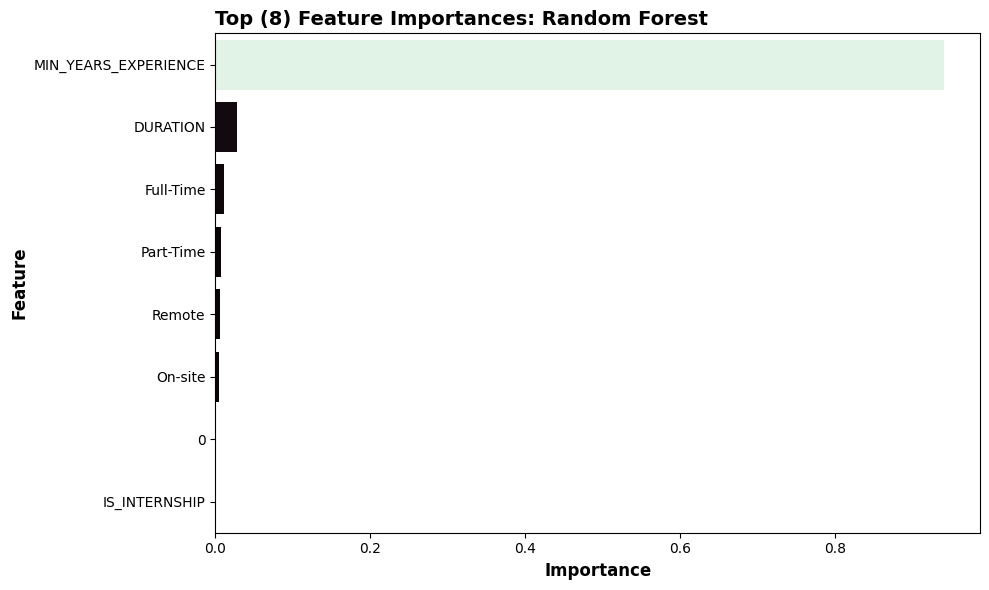

In [ ]:
#| eval: true
#| echo: true
#| fig-align: center

def clean_feature_name(feature_list):
    clean_names = []
    for name in feature_list:
        if isinstance(name, list):
            clean_names.append(", ".join(str(n) for n in name))
        elif isinstance(name, str) and name.startswith("["):
            clean_names.append(name.replace("[","").replace("]", "").replace("'", "").replace("'",'').strip())
        else:
            clean_names.append(str(name))
    return clean_names

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

importance_df["Feature"] = clean_feature_name(importance_df["Feature"])

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x="Importance", y="Feature", hue="Importance", palette="mako", legend=False)
plt.title("Top (8) Feature Importances: Random Forest", fontsize=14, fontweight='bold', loc='left')
plt.xlabel("Importance", fontsize=12, fontweight='bold')
plt.ylabel("Feature", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("output/rf_feature_importance.png", dpi=300)
plt.show()

# Feature Importance Summary

This analysis shows that the Minimum Years Experience is by far the most important feature in predicting salary, with a feature importance score of above .8. After that, there aren't any features that have a significant impact in my model, though I believe if I had added different categorical features it would have been more interesting.

In [ ]:
#---Comparison of all 3 Models: GLR, Polynomial GLR, Random Forest---
#| eval: true
#| echo: true
#| fig-align: center

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

#---Evaluate all 3 Models---

evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
residuals_df = summary.predictions.withColumn("squared_error", pow(col("SALARY") - col("prediction"), 2))

#GLR
glr_df = summary.predictions.select("SALARY", "prediction").toPandas().rename(columns={"prediction": "GLR"})
glr_r2 = evaluator_r2.evaluate(summary.predictions)
glr_rmse = residuals_df.select(avg(col("squared_error")).alias("mse")).select(sqrt(col("mse")).alias("rmse")).collect()[0]["rmse"]
glr_aic = summary.aic
glr_bic = len(summary.coefficientStandardErrors) * np.log(summary.numInstances) + summary.numInstances * np.log(summary.deviance / summary.numInstances)

#Polynomial GLR
poly_df = poly_preds.select("SALARY", "prediction").toPandas().rename(columns={"prediction": "Polynomial"})
poly_r2 = evaluator_r2.evaluate(poly_preds)
poly_rmse = np.sqrt(((poly_df["SALARY"]-poly_df["Polynomial"])**2).mean())
poly_aic = None
poly_bic = None

#Random Forest
rf_df = rf_predictions.select("SALARY", "prediction").toPandas().rename(columns={"prediction": "RandomForest"})
rf_r2 = evaluator_r2.evaluate(rf_predictions)
rf_rmse = np.sqrt(((rf_df["SALARY"]-rf_df["RandomForest"])**2).mean())
rf_aic = None
rf_bic = None

#Merge for Plotting
merged = glr_df.copy()
merged["Polynomial"] = poly_df["Polynomial"]
merged["RandomForest"] = rf_df["RandomForest"]

#Melt for Plotting
plot_df = merged.melt(id_vars="SALARY", var_name="Model", value_name="Predicted")
plot_df.head()



,SALARY,Model,Predicted
0,15860.0,GLR,76364.272870
1,22440.0,GLR,104756.726135
2,22880.0,GLR,82069.331370
3,23179.0,GLR,90743.038366
4,23585.0,GLR,78595.904958


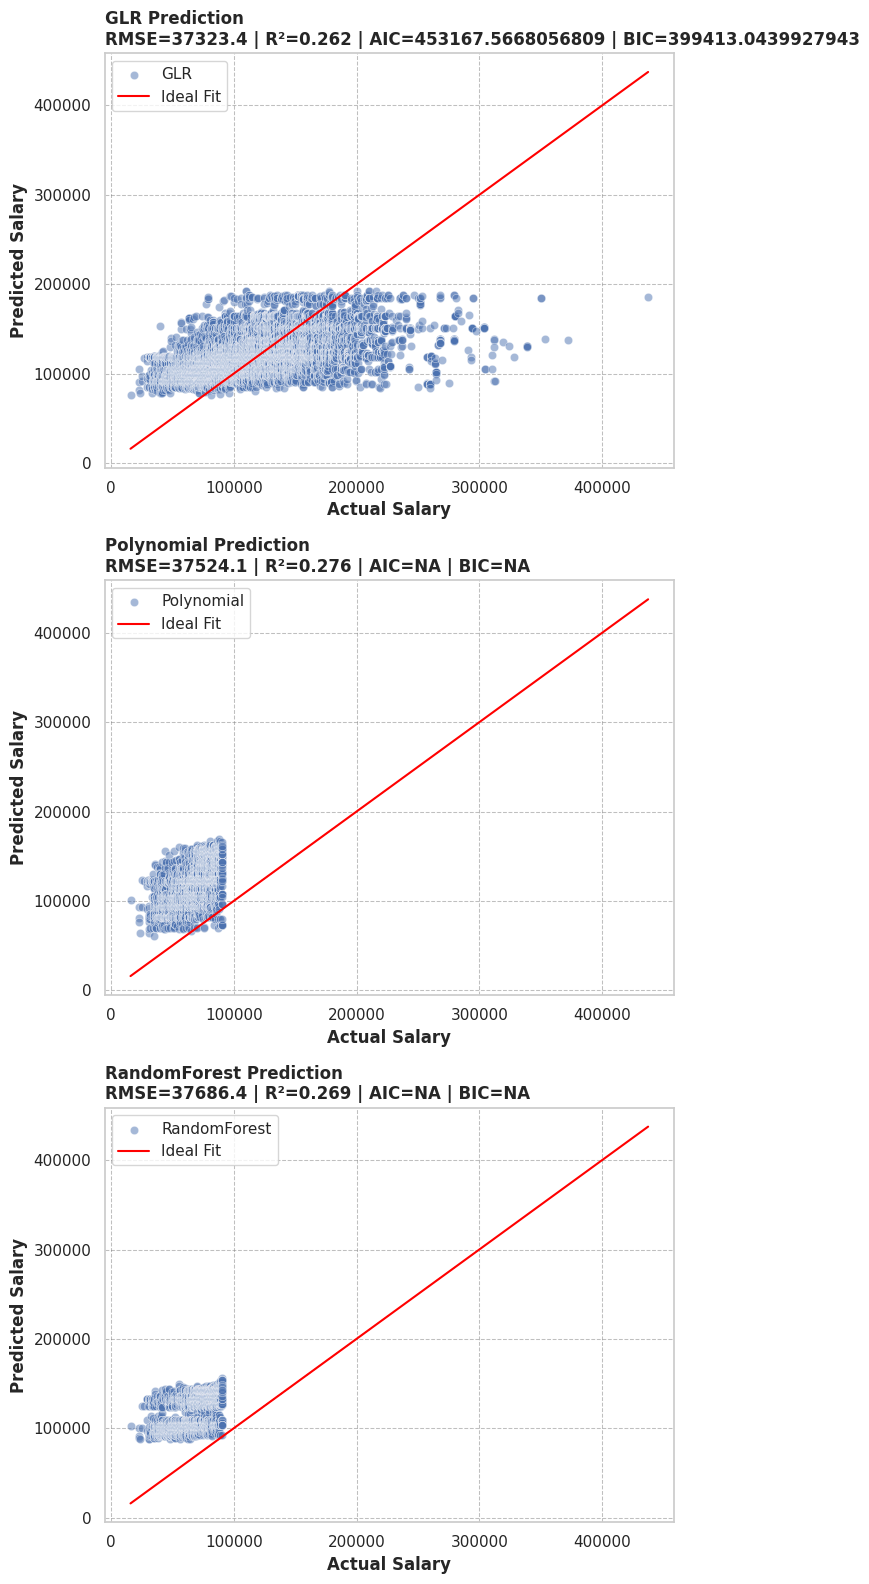

In [28]:
#| eval: true
#| echo: false
#| fig-align: center

plt.figure(figsize=(7, 16))
sns.set_theme(style="whitegrid")

models = {
    "GLR": (glr_rmse, glr_r2, glr_aic, glr_bic),
    "Polynomial": (poly_rmse, poly_r2, "NA", "NA"),
    "RandomForest": (rf_rmse, rf_r2, "NA", "NA")
}

for idx, model in enumerate(models.keys(), 1):
    plt.subplot(3, 1, idx)
    temp_df = plot_df[plot_df["Model"] == model]
    sns.scatterplot(data=temp_df, x="SALARY", y="Predicted", alpha=0.5, label=model)
    sns.lineplot(x=temp_df["SALARY"], y=temp_df["SALARY"], color="red", label="Ideal Fit")
    rmse, r2, aic, bic = models[model]
    plt.title(f"{model} Prediction\nRMSE={rmse:.1f} | R²={r2:.3f} | AIC={aic} | BIC={bic}", fontsize=12, fontweight='bold', loc='left')
    plt.xlabel("Actual Salary", fontsize=12, fontweight='bold')
    plt.ylabel("Predicted Salary", fontsize=12, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.75, color='gray')
    #plt.legend()

plt.tight_layout()
plt.savefig("output/model_comparison.png", dpi=300)
plt.show()



## 3 Model Comparison